# Streaming estimation of mean and std

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
import math


### Streaming calculation of mean and standard deviation
#### Batch mean and std
Suppose we are given a sequence of $T$ numbers: $x_1,x_2,\ldots,x_T$ and we want to estimate their mean and standard deviation:

* $\hat{\mu}_T \doteq \frac{1}{T} \sum_{t=1}^T x_t$
* $\hat{\sigma}_T=\sqrt{\sum_{t=1}^T (x_t-\hat{\mu}_T)^2}$

These estimates converge to the true mean and std as $T$ increases to $\infty$.

#### Stream computation
To perform the estimation calculation given above we need to go twice over the sequence, once to compute $\hat{\mu}_T$ and a second time to compute $\hat{\sigma}_T$. If we have a fast stream of data this might not be feasible.

On the other hand $\hat{\mu}_T \to \mu$ as $T \to \infty$. So we can use the current estimate of $\mu$ as a proxy for $\mu$. This allows us to generate a stream of estimates as follows. 

* We initialize the estimators:$\hat{\mu}_0=0, \hat{\sigma}_0=0$
* For each $t>0$ we get $x_t$ and update the estimators as follows:
* $\hat{\mu}_t = \frac{1}{t} x_t + \frac{t-1}{t} \hat{\mu}_{t-1}$
* $\hat{\sigma}^2_t = \frac{1}{t} (x_t-\hat{\mu}_t)^2+ \frac{t-1}{t} \hat{\sigma}^2_{t-1}$ 

These estimators will converge to the correct values if the sequence is IID, but the convergence will be slower than that of the batch method.

#### Exponential decay estimators
Often, when the sequences are very long, the elements are not IID but might have time varying mean and std.

In such cases a natural approach is to let $t$ increase from $0$ to $T$ and then stop increasing it an keep it at $T$. This is  **similar** (but not equal) to a "windowing" approach where at time $t$ we consider only the measurements $x_{t-T+1},\ldots, x_t$. However, windowing requires keeping the last $T$ measurements in memory.

In general we define the "Exponentially decaying estimators" for a decay rate $\alpha>0$ (in the case above $\alpha = \frac{1}{T}$) as follows:

* We initialize the estimators:$\hat{\mu}_0=0, \hat{\sigma}_0=0$
* For each $t>0$ we get $x_t$ and update the estimators as follows:
* $\hat{\mu}_t = \alpha x_t + (1-\alpha) \hat{\mu}_{t-1}$,
* $\hat{\sigma}^2_t = \alpha (x_t-\hat{\mu}_t)^2+ (1-\alpha) \hat{\sigma}^2_{t-1}$



##### Implementation
We now implement these estimators using classes that are a special case fo python **Iterators**.

In [18]:
# Using the generator pattern (an iterable)
class run_aver:
    ## Initialize the object
    def __init__(self,alpha=0.0):
        self.t = 0.0
        self.s = 0.0
        self.alpha = alpha

    def send(self,x):
        if self.alpha==0:
            self.s=(x + self.t*self.s)/(self.t+1.0)
        else:
            self.s=self.alpha*x + (1-self.alpha)*self.s                           
        self.t+=1.0
        residual=x-self.s
        return residual
    
    def get_state(self):
        return self.s

# compute the covariance over two signals with zero mean
class run_cov(object):
    ## Initialize the object
    def __init__(self,alpha=0.0,single=True):
        self.t = 0.0
        self.s = 0.0
        self.alpha = alpha
        self.single=single

    def send(self,x1,x2):
        if self.single:
            assert(x1==x2)
        x=x1*x2
        if self.alpha==0:
            self.s=(x + self.t*self.s)/(self.t+1.0)
        else:
            self.s=self.alpha*x + (1-self.alpha)*self.s                           
        self.t+=1.0
        if self.single:
            residual=x1/math.sqrt(self.s)
        else:
            residual = None
        return residual
    
    def get_variance(self):
        return self.s


In [25]:
## This function takes as input an input sequence and a setting for alpha.
## alpha=0 corresponds to taking the regular average.'
## It generates a figure with the different estimations and residuals
def plot_mean_std(a,alpha=0.0):
    sz=len(a)
    r1=np.zeros(sz)
    aver=np.zeros(sz)
    r2=np.zeros(sz)
    std=np.zeros(sz)

    Av=run_aver(alpha=alpha)
    Std=run_cov(alpha=0)

    for t in range(sz):
        r1[t]=Av.send(a[t])
        aver[t]=Av.get_state()
        r2[t]=Std.send(r1[t],r1[t])
        std[t]=Std.get_variance()

    print 'var(a)=',np.var(a),'var(r1)=',np.var(r1)
    plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(a,label='a')
    plt.plot(r1,label='residual 1')
    plt.plot(aver,linewidth=3.0,label='average')
    plt.plot(r2,label='residual 2')
    plt.plot(std,linewidth=3.0,label='STD')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid()


1000
var(a)= 13.0006870935 var(r1)= 1.99786792475


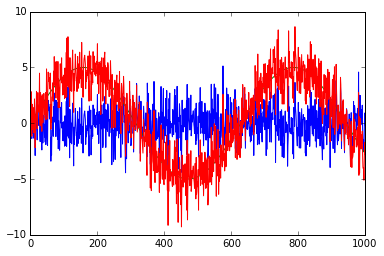

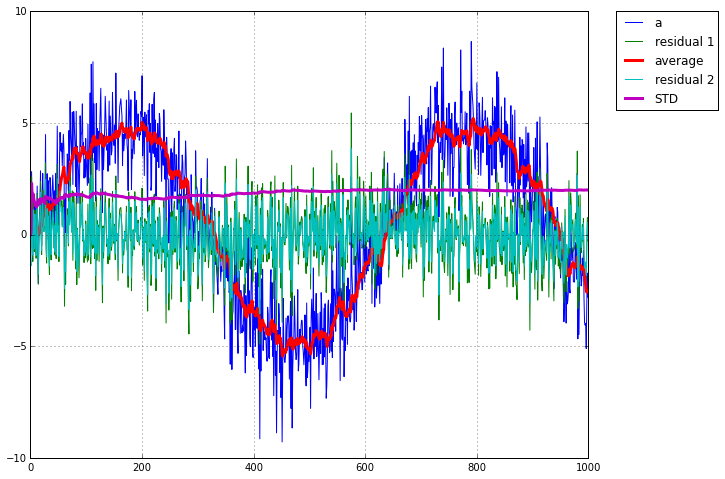

In [37]:
sz=1000; # length of input vector
scale=100.0
noise=np.random.normal(loc=0,scale=1.5,size=sz) #noise
signal=5*np.sin(np.arange(0,sz/scale,1/scale)) #signal
plt.plot(noise)
plt.plot(signal)

a= signal+noise
plt.plot(a)
print len(a)

plot_mean_std(a,alpha=0.1)


In [35]:
1/60.

0.016666666666666666

### Residuals
"Residuals" are the part of the signal that remains after the part of the signal that is modeled has been removed.

In the code above we use two residuals:

1. **r1** is the original signal **x** after the estimated mean has been subtracted out. Assuming that the estimate of the mean is accurate, the residual will have a mean of zero.
2. **r2** this is the first residual **r1** after it was divided by the std. Assuming the estimates of he mean and std are accurate the residual has mean zero and std 1.

This is the basic idea of "modeling the residuals". We assume that the data is a sum of "signal" - a part that can be modeled, and "noise" - a part that cannot be modeled. The usuall assymption about the unmodeled part is that it is "white noise" = the elements are assumed to be drawn IID from a normal distribution with mean 0 and std 1.

By iteratively modeling the sequence and computing a residual we "extract" all of the signal and wha remains is white noise.

### DSE Class Work
Construct two sequences to be the sum of a sinusoidal signal and noise in the following four combinations.

Signal:
* Use the same signal for both sequences  (have at least 10 iterations/periods/waves in the data)
* make one sinusoid have double the wavelength as the other

Noise
* Use the same noise for both sequences
* Use independent noise for both sequence.

Create a function, similar to plot_mean_std which computes the (local) correlation coefficient between the two signals.

Create plots for the different signal pairs described above.

## CSE255 HW1

You will be given two files, each of 1-5GB and each consisting of a sequence of 64 bit floating point numbers. The files can be read using `numpy.fromfile()`

Your task is to write streaming algorithms that will calculate the mean and std of each sequence and the correlation coefficient between them. You should do that both on the sequence as a whole and on using an exponentially weighted average defined by a parameter $\alpha$.

Analyze the performance of your code on your computer, generate the appropriate figures to visualize performance 
and find good chunk sizes to use.

We will supply test files, you are encouraged to generate others.

Your notebook will also be run by the TA on his laptop, using data that will not be available to you. You code should work on that data.

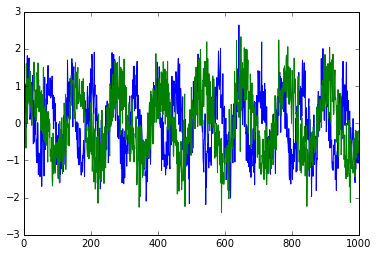

In [20]:
sz=1000; # length of input vector
scale1=10.0
scale2=20.0
noise1=np.random.normal(loc=0,scale=0.5,size=sz) 
noise2=np.random.normal(loc=0,scale=0.5,size=sz) 
sig1=np.sin(np.arange(0,sz/scale1,1/scale1))
sig2=np.sin(np.arange(0,sz/scale2,1/scale2))

plt.plot(sig1+noise1)
plt.plot(sig2+noise2)

